# Ensemble Learning on California Housing Data

The script demonstrates **bagging**, **boosting**, and **stacking** using the California Housing dataset. This will help clarify these ensemble learning concepts through practical application.

## Load libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    RandomForestRegressor,  # Bagging example
    GradientBoostingRegressor,  # Boosting example
    AdaBoostRegressor,  # Another boosting example
    BaggingRegressor  # Explicit bagging
)
from sklearn.ensemble import StackingRegressor  # Stacking
import time
from sklearn.datasets import fetch_california_housing

## Load data

In [8]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
X = pd.DataFrame(data=housing['data'], columns=housing['feature_names'])
y = housing['target']

## Pre-process data

In [10]:
# Let's split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Dictionary to store results
results = {}

In [16]:
print("California Housing Dataset Analysis with Ensemble Methods")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print("-" * 50)

California Housing Dataset Analysis with Ensemble Methods
Training set size: (16512, 8)
Test set size: (4128, 8)
--------------------------------------------------


In [18]:
# Helper function to evaluate and store model results
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results[name] = {
        'model': model,
        'RMSE': rmse,
        'R2': r2,
        'Training Time': train_time,
        'predictions': y_pred
    }
    
    print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}, Training Time: {train_time:.2f}s")
    return model

## Bagging (Bootstrap Aggregating)

- Creates multiple models trained on random subsets of data with replacement.
- Combines predictions by averaging (for regression problems)

Implemented using:
- BaggingRegressor with decision trees as base estimators
- RandomForestRegressor (which uses bagging with feature randomization)

**Purpose**: Reduces variance and prevents overfitting

In [20]:
# -------------------------------------------------
# 1. BAGGING METHODS
# -------------------------------------------------
print("\n1. BAGGING METHODS")
print("Bagging (Bootstrap Aggregating) builds multiple models on random subsets of data")
print("and averages predictions to reduce variance and overfitting.")
print("-" * 50)


1. BAGGING METHODS
Bagging (Bootstrap Aggregating) builds multiple models on random subsets of data
and averages predictions to reduce variance and overfitting.
--------------------------------------------------


In [22]:
# Simple Decision Tree as baseline
dt = DecisionTreeRegressor(random_state=42)
evaluate_model(dt, "Decision Tree (Baseline)", X_train_scaled, y_train, X_test_scaled, y_test)

Decision Tree (Baseline) - RMSE: 0.7028, R2: 0.6230, Training Time: 0.52s


DecisionTreeRegressor(random_state=42)

In [28]:
# Explicit Bagging with Decision Trees
bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=100,
    random_state=42,
    bootstrap=True,  # Enable bootstrapping (sampling with replacement)
    oob_score=True,  # Use out-of-bag samples to estimate the generalization score
    n_jobs=-1  # Use all available processors
)
bagging_model = evaluate_model(bagging, "Explicit Bagging (100 Decision Trees)", 
                               X_train_scaled, y_train, X_test_scaled, y_test)
print(f"Out-of-bag score: {bagging.oob_score_:.4f}")

Explicit Bagging (100 Decision Trees) - RMSE: 0.5057, R2: 0.8048, Training Time: 6.05s
Out-of-bag score: 0.8071


In [26]:
# Random Forest (an implementation of bagging with decision trees and feature randomization)
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model = evaluate_model(rf, "Random Forest", X_train_scaled, y_train, X_test_scaled, y_test)

Random Forest - RMSE: 0.5051, R2: 0.8053, Training Time: 2.33s


## Boosting

- Builds models sequentially where each model focuses on correcting errors from previous models

Implemented using:
- AdaBoostRegressor (adaptive boosting)
- GradientBoostingRegressor (gradient boosting)

**Purpose**: Reduces bias and improves predictive accuracy by focusing on difficult cases

In [30]:
# -------------------------------------------------
# 2. BOOSTING METHODS
# -------------------------------------------------
print("\n2. BOOSTING METHODS")
print("Boosting builds models sequentially, with each model focusing on the errors of the previous one")
print("to reduce bias and improve predictive accuracy.")
print("-" * 50)


2. BOOSTING METHODS
Boosting builds models sequentially, with each model focusing on the errors of the previous one
to reduce bias and improve predictive accuracy.
--------------------------------------------------


In [34]:
# AdaBoost
ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=4),
    n_estimators=100,
    random_state=42,
    learning_rate=0.1
)
ada_model = evaluate_model(ada, "AdaBoost", X_train_scaled, y_train, X_test_scaled, y_test)

AdaBoost - RMSE: 0.6945, R2: 0.6320, Training Time: 4.19s


In [36]:
# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    subsample=0.8  # Use 80% of samples for each boosting stage
)
gb_model = evaluate_model(gb, "Gradient Boosting", X_train_scaled, y_train, X_test_scaled, y_test)

Gradient Boosting - RMSE: 0.5139, R2: 0.7985, Training Time: 4.20s


## Stacking

- Combines predictions from multiple "base models" using another "meta-model"

Implemented using StackingRegressor with:
- Base models: Decision Tree, Random Forest, and Gradient Boosting
- Meta-model: Linear Regression

**Purpose**: Leverages strengths of diverse algorithms for better overall performance

In [38]:
# -------------------------------------------------
# 3. STACKING
# -------------------------------------------------
print("\n3. STACKING")
print("Stacking combines predictions from multiple models (base models)")
print("using another model (meta-model) to make final predictions.")
print("-" * 50)


3. STACKING
Stacking combines predictions from multiple models (base models)
using another model (meta-model) to make final predictions.
--------------------------------------------------


In [40]:
# Define base models for stacking
base_models = [
    ('dt', DecisionTreeRegressor(random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]

# Define meta-model
meta_model = LinearRegression()

# Create stacking ensemble
stacking = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5  # 5-fold cross-validation for base model predictions
)
stacking_model = evaluate_model(stacking, "Stacking Ensemble", X_train_scaled, y_train, X_test_scaled, y_test)

Stacking Ensemble - RMSE: 0.5063, R2: 0.8043, Training Time: 17.01s


## Model performance

Visualization of model performance metrics (RMSE and R²) and a feature importance analysis for models that support it. 

In [42]:
# -------------------------------------------------
# COMPARATIVE ANALYSIS
# -------------------------------------------------
print("\nCOMPARATIVE ANALYSIS")
print("-" * 50)

# Sort models by performance (RMSE)
sorted_results = sorted(results.items(), key=lambda x: x[1]['RMSE'])
best_model_name = sorted_results[0][0]
print(f"Best performing model: {best_model_name}, RMSE: {sorted_results[0][1]['RMSE']:.4f}")


COMPARATIVE ANALYSIS
--------------------------------------------------
Best performing model: Random Forest, RMSE: 0.5051


In [44]:
# Visualize results
models = list(results.keys())
rmse_values = [results[model]['RMSE'] for model in models]
r2_values = [results[model]['R2'] for model in models]
training_times = [results[model]['Training Time'] for model in models]

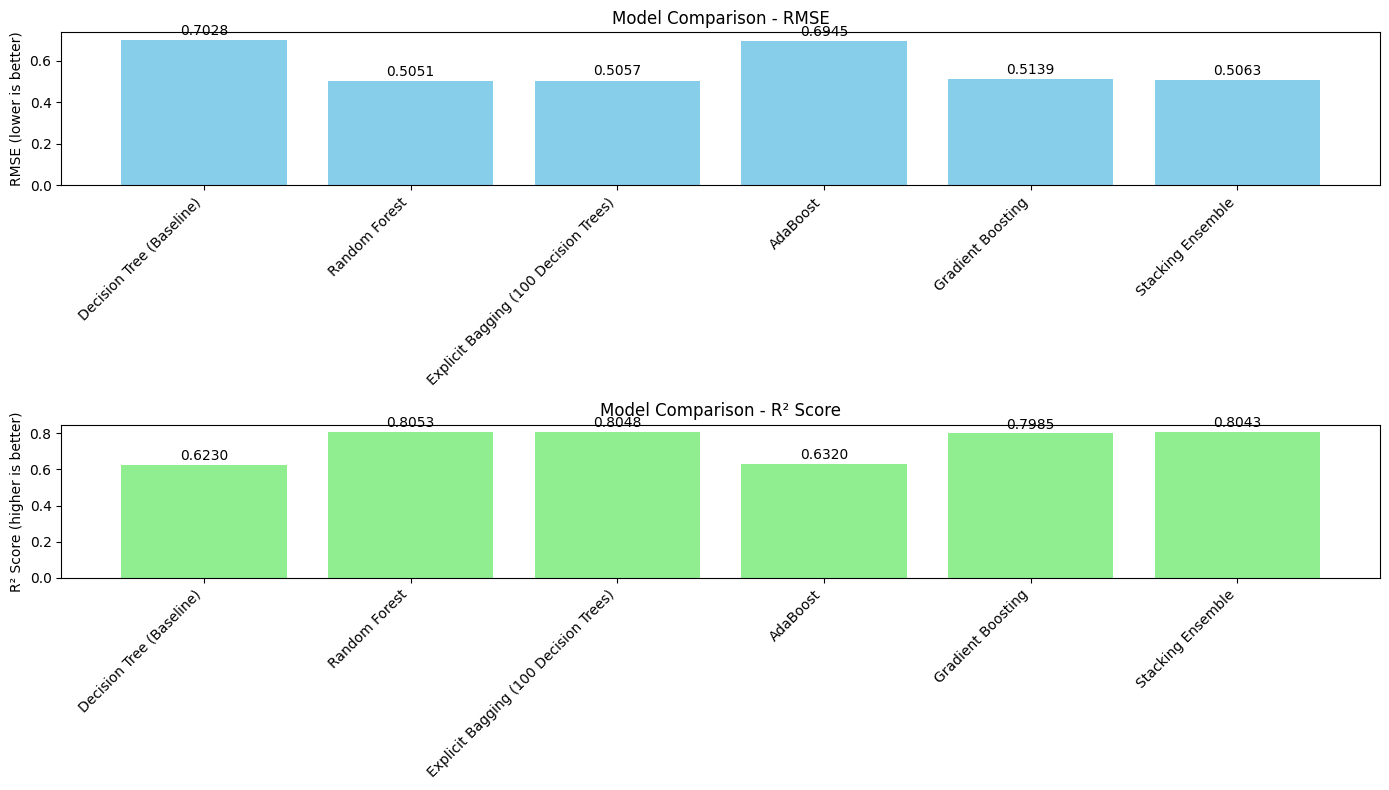

In [50]:
# Plot RMSE comparison
plt.figure(figsize=(14, 8))
plt.subplot(2, 1, 1)
bars = plt.bar(models, rmse_values, color='skyblue')
plt.ylabel('RMSE (lower is better)')
plt.title('Model Comparison - RMSE')
plt.xticks(rotation=45, ha='right')
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.01,
             f'{value:.4f}', 
             ha='center', va='bottom', rotation=0)

# Plot R² comparison
plt.subplot(2, 1, 2)
bars = plt.bar(models, r2_values, color='lightgreen')
plt.ylabel('R² Score (higher is better)')
plt.title('Model Comparison - R² Score')
plt.xticks(rotation=45, ha='right')
for bar, value in zip(bars, r2_values):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height() + 0.01,
             f'{value:.4f}', 
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('ensemble_comparison.png')
plt.show()


FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
Feature ranking (Random Forest):
1. MedInc (0.5249)
2. AveOccup (0.1384)
3. Latitude (0.0889)
4. Longitude (0.0886)
5. HouseAge (0.0546)
6. AveRooms (0.0443)
7. Population (0.0306)
8. AveBedrms (0.0296)


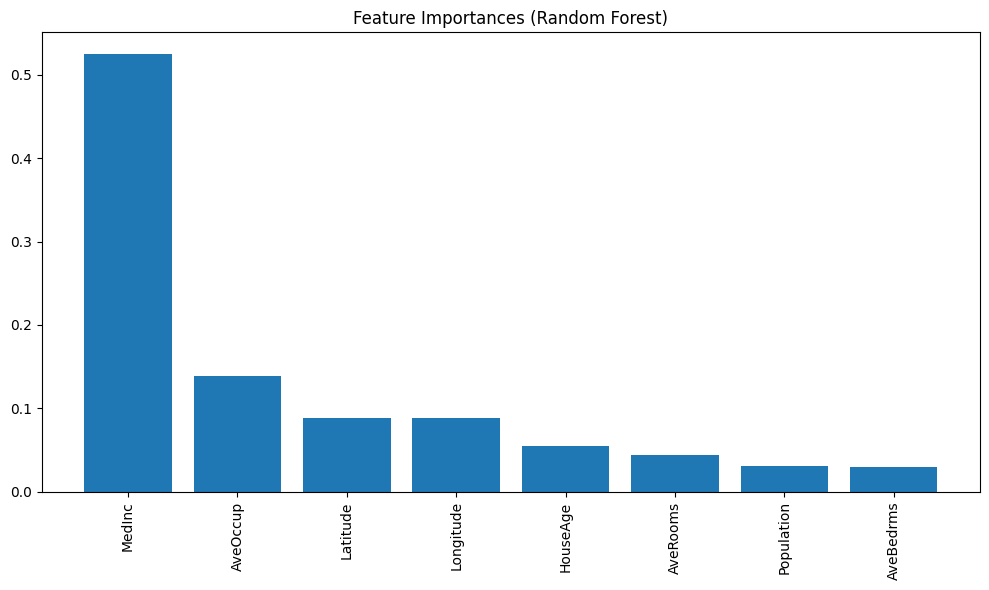

In [52]:
# -------------------------------------------------
# Feature importance analysis (for models that support it)
# -------------------------------------------------
print("\nFEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

if hasattr(rf_model, 'feature_importances_'):
    # Get feature importances from Random Forest
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Print feature ranking
    print("Feature ranking (Random Forest):")
    for f in range(X.shape[1]):
        print(f"{f+1}. {X.columns[indices[f]]} ({importances[indices[f]]:.4f})")
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances (Random Forest)")
    plt.bar(range(X.shape[1]), importances[indices], align="center")
    plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

In [54]:
# -------------------------------------------------
# SUMMARY OF ENSEMBLE METHODS
# -------------------------------------------------
print("\nSUMMARY OF ENSEMBLE METHODS")
print("-" * 50)
print("""
BAGGING (Bootstrap Aggregating):
- Builds multiple independent models in parallel on random subsets of data
- Combines results by averaging (regression) or voting (classification)
- Reduces variance and helps prevent overfitting
- Examples: Random Forest, Bagging Classifier/Regressor

BOOSTING:
- Builds models sequentially, each focusing on the errors of previous models
- Gives higher weight to misclassified instances
- Reduces bias and gradually improves accuracy
- Examples: AdaBoost, Gradient Boosting, XGBoost

STACKING:
- Combines predictions from different models using a meta-model
- Base models are trained on the original dataset
- Meta-model is trained on the predictions of base models
- Leverages strengths of diverse algorithms
- Example: Stacking Classifier/Regressor
""")


SUMMARY OF ENSEMBLE METHODS
--------------------------------------------------

BAGGING (Bootstrap Aggregating):
- Builds multiple independent models in parallel on random subsets of data
- Combines results by averaging (regression) or voting (classification)
- Reduces variance and helps prevent overfitting
- Examples: Random Forest, Bagging Classifier/Regressor

BOOSTING:
- Builds models sequentially, each focusing on the errors of previous models
- Gives higher weight to misclassified instances
- Reduces bias and gradually improves accuracy
- Examples: AdaBoost, Gradient Boosting, XGBoost

STACKING:
- Combines predictions from different models using a meta-model
- Base models are trained on the original dataset
- Meta-model is trained on the predictions of base models
- Leverages strengths of diverse algorithms
- Example: Stacking Classifier/Regressor

